In [10]:
%pip install gensim

   ---------------------------------------- 0.0/24.4 MB ? eta -:--:--
   ----------- ---------------------------- 6.8/24.4 MB 37.1 MB/s eta 0:00:01
   ----------------------- ---------------- 14.2/24.4 MB 36.5 MB/s eta 0:00:01
   ------------------------------------ --- 22.0/24.4 MB 37.0 MB/s eta 0:00:01
   ---------------------------------------- 24.4/24.4 MB 35.2 MB/s eta 0:00:00

   -------------------- ------------------- 1/2 [gensim]
   -------------------- ------------------- 1/2 [gensim]
   -------------------- ------------------- 1/2 [gensim]
   -------------------- ------------------- 1/2 [gensim]
   -------------------- ------------------- 1/2 [gensim]
   -------------------- ------------------- 1/2 [gensim]
   -------------------- ------------------- 1/2 [gensim]
   -------------------- ------------------- 1/2 [gensim]
   ---------------------------------------- 2/2 [gensim]

Note: you may need to restart the kernel to use updated packages.


# Classification using Word2Vec and K-Nearest Neighbors (KNN)

This notebook demonstrates text classification using:
1.  **Feature Engineering**: Word2Vec (Word Embeddings) to convert text into numerical vectors.
2.  **Classification Algorithm**: K-Nearest Neighbors (KNN).

Target Label: `Label`
Content: `Cleaned_Content`

In [11]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure reproducible results
np.random.seed(42)

In [ ]:
# Load the dataset
file_path = '../cleaned_data.csv'
data = pd.read_csv(file_path)

# Drop rows with missing values
data = data.dropna(subset=['Label', 'Cleaned_Content'])

# Display the first few rows
data.head()

,Content,Paper Name,Label,Cleaned_Content
0,Insulin resistance is a condition characterize...,Brain insulin resistance mediated cognitive im...,Alzheimer's Disease,insulin resistance condition characterized att...
1,substrate 1 (IRS1)/PI3K/AKT and IGF-1 receptor...,Brain insulin resistance mediated cognitive im...,Alzheimer's Disease,substrate irs pi akt igf receptor igf irs pi p...
2,Prolactin is a pituitary anterior lobe hormone...,Hyperprolactinemia and Brain Health: Exploring...,Alzheimer's Disease,prolactin pituitary anterior lobe hormone play...
3,Lecanemab is an amyloid-targeted antibody indi...,Severe Persistent Urinary Retention Following ...,Alzheimer's Disease,lecanemab amyloid targeted antibody indicated ...
4,Glycoprotein 88 (GP88) is a secreted biomarker...,An Impedimetric Immunosensor for Progranulin D...,Alzheimer's Disease,glycoprotein gp secreted biomarker overexpress...


In [13]:
# Preprocessing for Word2Vec: Tokenize the text
# Since the content is already cleaned, we can simply split by whitespace
sentences = [text.split() for text in data['Cleaned_Content']]

# Check the first sentence
print(f"First sentence length: {len(sentences[0])}")
print(sentences[0][:10])  # Print first 10 words

First sentence length: 67
['insulin', 'resistance', 'condition', 'characterized', 'attenuated', 'biological', 'response', 'presence', 'normal', 'elevated']


In [14]:
# Train Word2Vec model
# vector_size: Dimensionality of the word vectors
# window: Maximum distance between the current and predicted word within a sentence
# min_count: Ignored all words with total frequency lower than this
# workers: Use these many worker threads to train the model
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

print("Word2Vec model trained successfully.")

Word2Vec model trained successfully.


In [15]:
# Function to generate document vectors by averaging word vectors
def document_vector(doc):
    # Filter out words that are not in the vocabulary
    doc = [word for word in doc if word in w2v_model.wv.key_to_index]
    if len(doc) == 0:
        return np.zeros(w2v_model.vector_size)
    return np.mean(w2v_model.wv[doc], axis=0)

# Create feature matrix X
X = np.array([document_vector(doc) for doc in sentences])
y = data['Label']

print("Shape of feature matrix X:", X.shape)

Shape of feature matrix X: (1641, 100)


In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])

Training set size: 1312
Testing set size: 329


In [17]:
# Initialize KNN Classifier
# n_neighbors can be tuned. Starting with 5.
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Train the classifier
knn_classifier.fit(X_train, y_train)

print("KNN Model training completed.")

KNN Model training completed.


In [18]:
# Make predictions
y_pred = knn_classifier.predict(X_test)

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.2340

Classification Report:
                         precision    recall  f1-score   support

    Alzheimer's Disease       0.27      0.35      0.30        71
Frontotemporal Dementia       0.24      0.12      0.16        77
     Lewy Body Dementia       0.32      0.38      0.35        60
    Parkinson's Disease       0.10      0.14      0.12        59
      Vascular Dementia       0.24      0.19      0.21        62

               accuracy                           0.23       329
              macro avg       0.24      0.24      0.23       329
           weighted avg       0.24      0.23      0.23       329



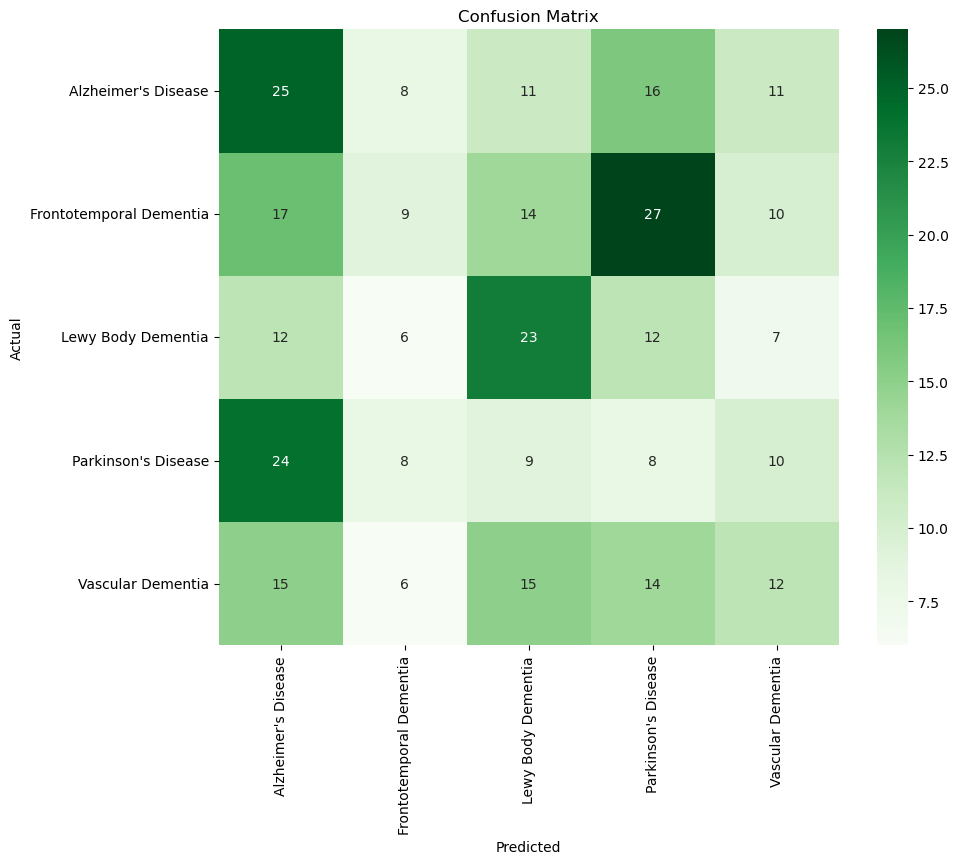

In [19]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=knn_classifier.classes_, yticklabels=knn_classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [21]:
# Optimization: Try KNN with Cosine Similarity
# Standard KNN uses Euclidean distance. For text vectors, Cosine distance is often better.
knn_cosine = KNeighborsClassifier(n_neighbors=9, metric='cosine') # Increased k slightly
knn_cosine.fit(X_train, y_train)

y_pred_cosine = knn_cosine.predict(X_test)

print("Accuracy with Cosine Similarity:", accuracy_score(y_test, y_pred_cosine))
print("\nClassification Report (Cosine):")
print(classification_report(y_test, y_pred_cosine))

Accuracy with Cosine Similarity: 0.3191489361702128

Classification Report (Cosine):
                         precision    recall  f1-score   support

    Alzheimer's Disease       0.29      0.38      0.33        71
Frontotemporal Dementia       0.50      0.16      0.24        77
     Lewy Body Dementia       0.36      0.45      0.40        60
    Parkinson's Disease       0.22      0.32      0.26        59
      Vascular Dementia       0.38      0.32      0.35        62

               accuracy                           0.32       329
              macro avg       0.35      0.33      0.32       329
           weighted avg       0.36      0.32      0.31       329



In [20]:
# Create a DataFrame to check Class Distribution
class_counts = data['Label'].value_counts()
print("Class Distribution:")
print(class_counts)

# Calculate baseline accuracy (if we just guessed the most frequent class)
baseline_acc = class_counts.max() / class_counts.sum()
print(f"\nBaseline Accuracy (Majority Class): {baseline_acc:.4f}")

Class Distribution:
Label
Vascular Dementia          350
Alzheimer's Disease        339
Parkinson's Disease        338
Lewy Body Dementia         319
Frontotemporal Dementia    295
Name: count, dtype: int64

Baseline Accuracy (Majority Class): 0.2133
